In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [46]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [39]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','waterfront','view','lat','long'])
    ## removing duplicates
    df=df.drop_duplicates()
    return df

In [41]:
re_df= load_original_data()
re_df=clean_data(re_df)

In [42]:
re_df.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [43]:
re_df[['condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

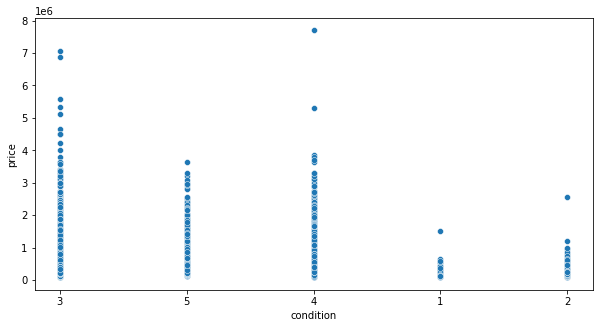

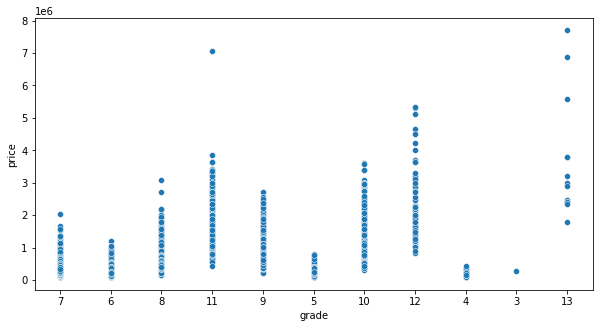

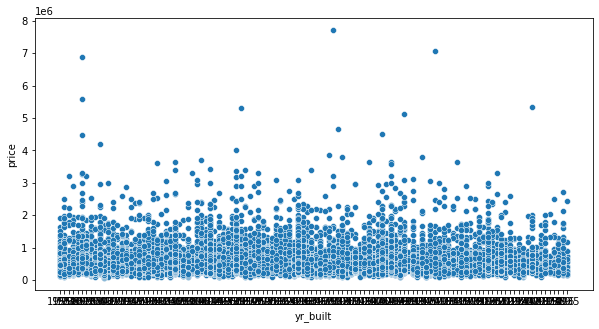

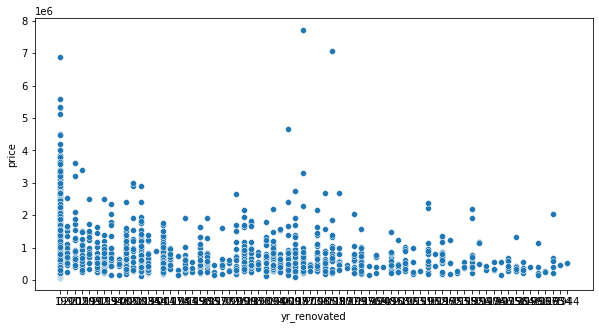

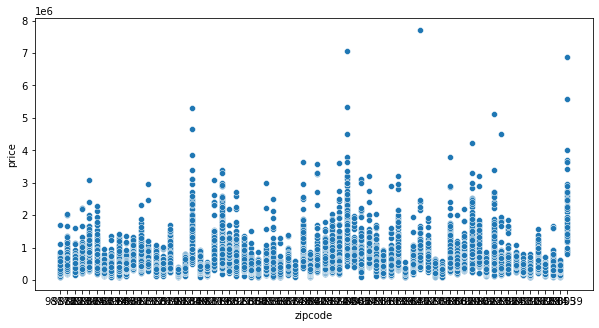

In [44]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

In [45]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   bedrooms       21597 non-null  int64         
 2   bathrooms      21597 non-null  float64       
 3   sqft_living    21597 non-null  int64         
 4   sqft_lot       21597 non-null  int64         
 5   floors         21597 non-null  float64       
 6   condition      21597 non-null  object        
 7   grade          21597 non-null  object        
 8   sqft_above     21597 non-null  int64         
 9   sqft_basement  21597 non-null  int64         
 10  yr_built       21597 non-null  object        
 11  yr_renovated   21597 non-null  object        
 12  zipcode        21597 non-null  object        
 13  sqft_living15  21597 non-null  int64         
 14  sqft_lot15     21597 non-null  int64         
 15  price          2159

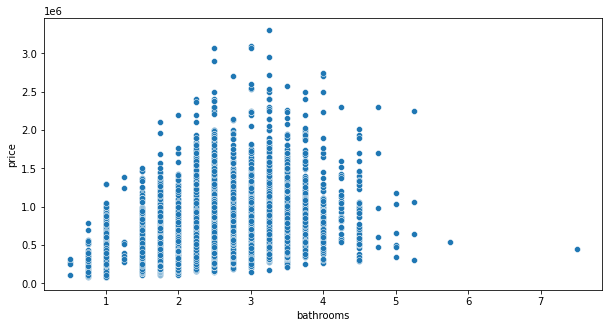

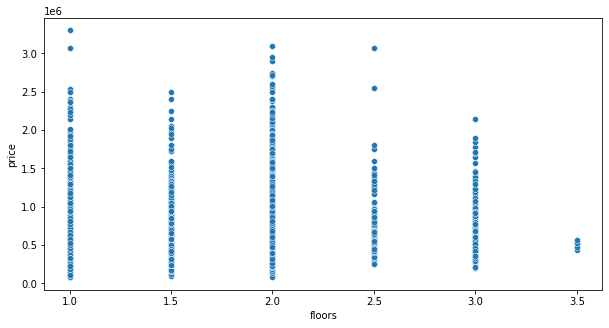

In [53]:
for c in re_df.select_dtypes(float):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

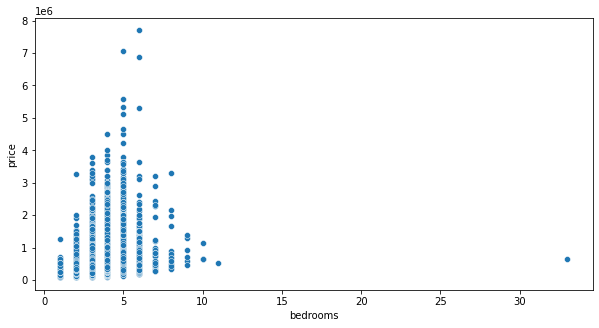

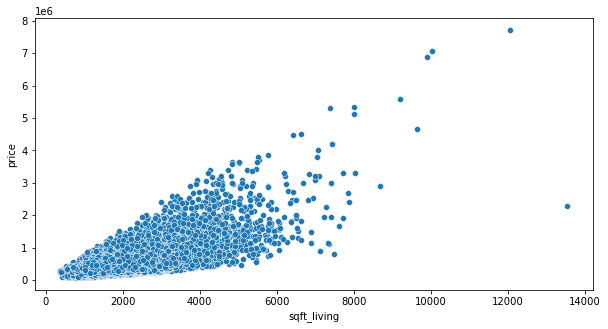

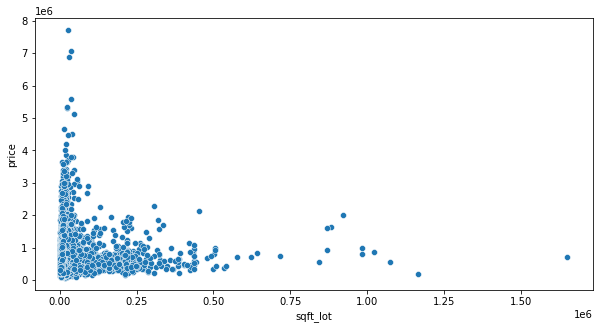

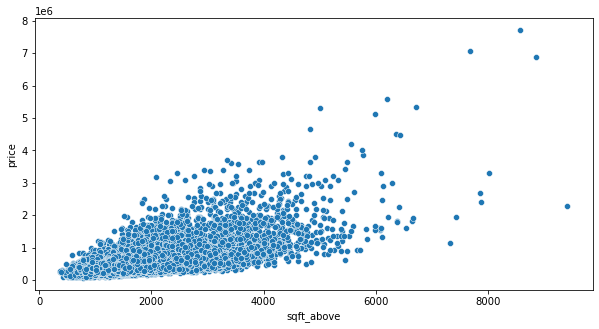

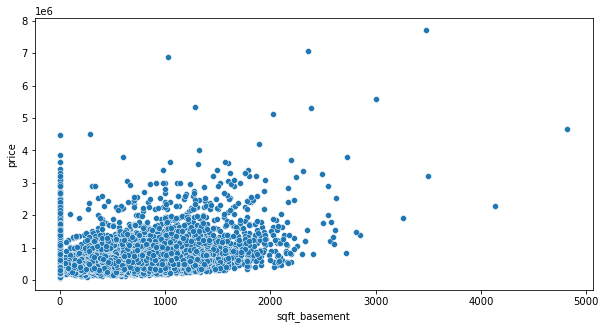

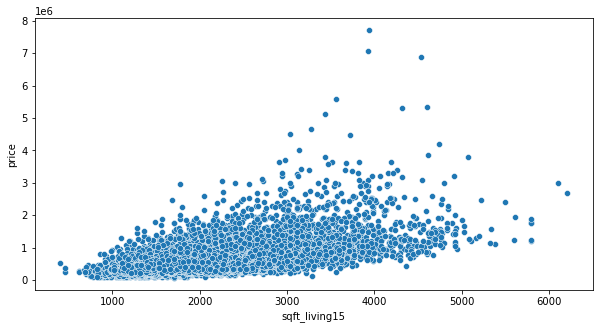

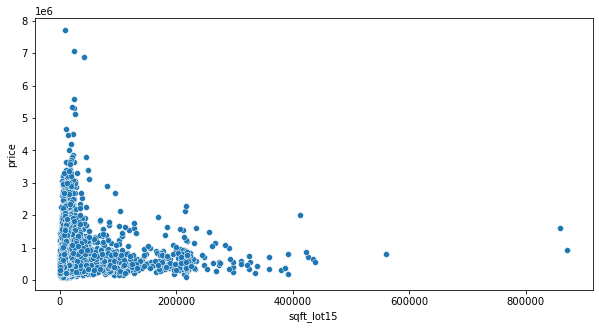

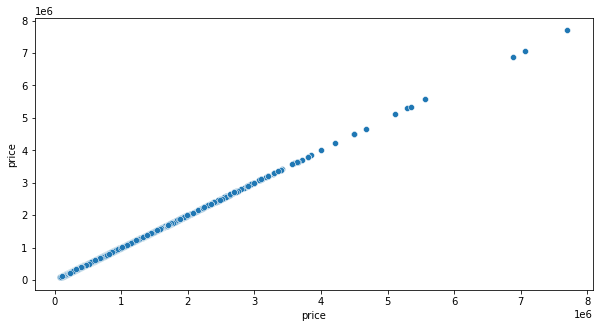

In [47]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

In [62]:
re_df

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,price
0,2014-10-13,3,1.00,1180,5650,1.0,3,7,1180,0,1955,0,98178,1340,5650,221900
1,2014-12-09,3,2.25,2570,7242,2.0,3,7,2170,400,1951,1991,98125,1690,7639,538000
2,2015-02-25,2,1.00,770,10000,1.0,3,6,770,0,1933,0,98028,2720,8062,180000
3,2014-12-09,4,3.00,1960,5000,1.0,5,7,1050,910,1965,0,98136,1360,5000,604000
4,2015-02-18,3,2.00,1680,8080,1.0,3,8,1680,0,1987,0,98074,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,3,2.50,1530,1131,3.0,3,8,1530,0,2009,0,98103,1530,1509,360000
21593,2015-02-23,4,2.50,2310,5813,2.0,3,8,2310,0,2014,0,98146,1830,7200,400000
21594,2014-06-23,2,0.75,1020,1350,2.0,3,7,1020,0,2009,0,98144,1020,2007,402101
21595,2015-01-16,3,2.50,1600,2388,2.0,3,8,1600,0,2004,0,98027,1410,1287,400000


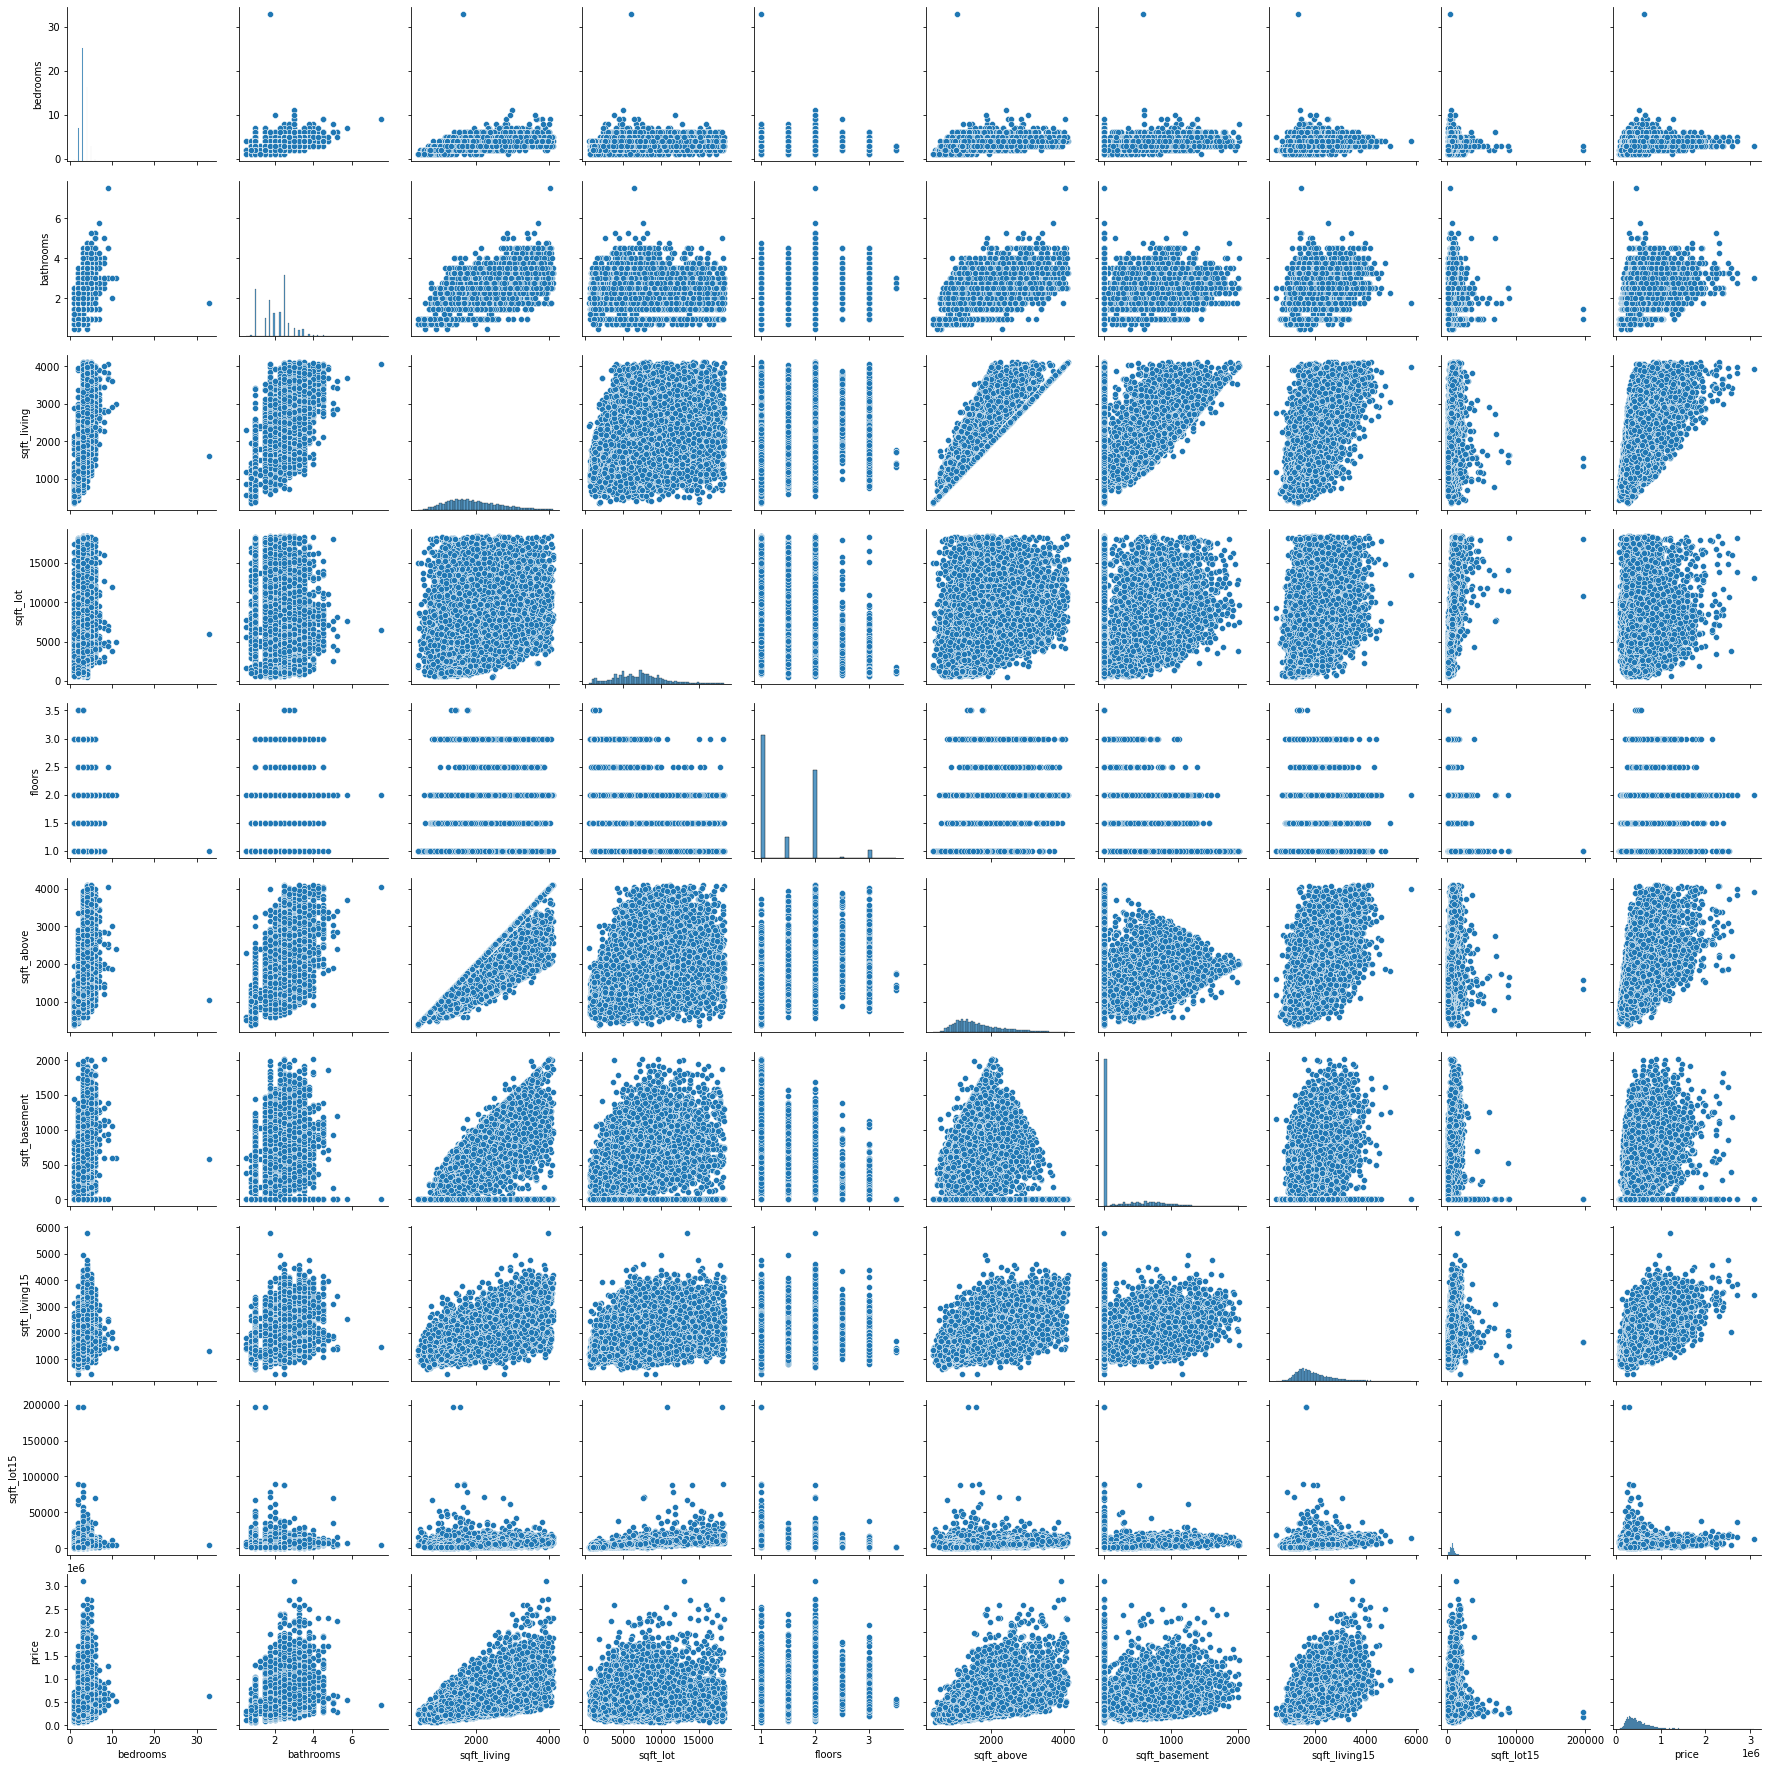

In [70]:
#Data transformation

sns.pairplot(re_df)
plt.show()

In [71]:
#checking correlation
re_df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.486592,0.597427,0.193536,0.152290,0.475779,0.278215,0.372728,0.118528,0.271133
bathrooms,0.486592,1.000000,0.714522,-0.010239,0.512780,0.633892,0.222492,0.523909,-0.018385,0.435491
sqft_living,0.597427,0.714522,1.000000,0.226777,0.342895,0.840643,0.390450,0.736261,0.149902,0.614811
sqft_lot,0.193536,-0.010239,0.226777,1.000000,-0.344442,0.181445,0.104174,0.277539,0.699146,0.046490
floors,0.152290,0.512780,0.342895,-0.344442,1.000000,0.540323,-0.294601,0.264163,-0.260031,0.252030
sqft_above,0.475779,0.633892,0.840643,0.181445,0.540323,1.000000,-0.170372,0.705635,0.125106,0.499222
sqft_basement,0.278215,0.222492,0.390450,0.104174,-0.294601,-0.170372,1.000000,0.140091,0.060073,0.269995
sqft_living15,0.372728,0.523909,0.736261,0.277539,0.264163,0.705635,0.140091,1.000000,0.227062,0.548780
sqft_lot15,0.118528,-0.018385,0.149902,0.699146,-0.260031,0.125106,0.060073,0.227062,1.000000,0.030801
price,0.271133,0.435491,0.614811,0.046490,0.252030,0.499222,0.269995,0.548780,0.030801,1.000000


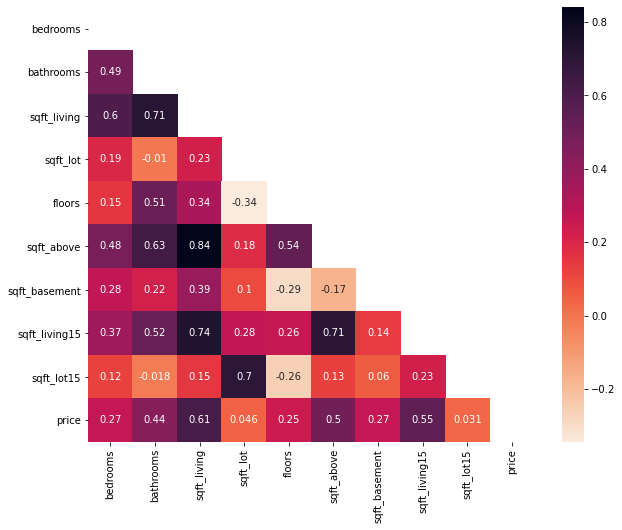

In [72]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals_features.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()